In [2]:
import os
import sys
from typing import Tuple
from datetime import datetime
from pathlib import Path


def recursive_root(path: str, find="sumo-uc-23"):
    if os.path.split(path)[-1] == find:
        return Path(path)
    return recursive_root(os.path.split(path)[0], find=find)


ROOT = recursive_root(os.path.abspath("."))
sys.path.append(str(ROOT))


In [3]:
import numpy as np
import pandas as pd
import utm
import polars as pl

from shapely.geometry import Point, Polygon, LineString
from src.data_analysis import AnalysisRadar
from innosent_api.utils.approach_info import ApproachInfo


## Creating Radar Objects


In [4]:
radars_df = pl.scan_parquet(
    "/Volumes/BittleLab/7 DOE Project/radar-data/new-format/13_*.parquet"
)

# # only keep data thats within start and end time
radars_df = radars_df.with_columns([
    pl.col("_time").dt.with_time_zone("America/Chicago").alias("time_cst")
]).filter(
    (pl.col("time_cst").dt.hour() >= 5)
    & (pl.col("time_cst").dt.hour() <= 12)
    & (pl.col("time_cst").dt.day() == 13)
).collect()

# def get_df_from_polars(radar: AnalysisRadar, pl_df: pl.DataFrame) -> pd.DataFrame:
#     ip_address = f"10.160.7.{radar.name.split('radar')[-1].strip()}"
#     df = pl_df.filter(pl.col("radar") == ip_address)

#     return df.to_pandas()


In [6]:
# radars_df = pl.scan_parquet(
#     "/Volumes/BittleLab/7 DOE Project/radar-data/new_new_format/*.parquet"
# )

# radars_df = radars_df.with_columns([
#     (pl.col("time") / 1000).cast(pl.Datetime).dt.with_time_zone('UTC').alias("time_utc"),
#     (pl.col("time") / 1000).cast(pl.Datetime).dt.with_time_zone('America/Chicago').alias("time_cst"),
# ]).filter(
#     (pl.col("time_cst").dt.hour() >= 5)
#     & (pl.col("time_cst").dt.hour() <= 12)
#     # & (pl.col("time_cst").dt.day() == 13)
# ).collect()

# def get_df_from_polars(radar: AnalysisRadar, pl_df: pl.DataFrame) -> pd.DataFrame:
#     ip_address = f"10.160.7.{radar.name.split('radar')[-1].strip()}"
#     df = pl_df.filter(pl.col("radar") == ip_address)

#     return df.to_pandas()


In [7]:
radars_df = pl.read_parquet(
    "/Volumes/BittleLab/7 DOE Project/radar-data/prepared_data/2_6_23_ALL_Radars.parquet"
)

# there are some duplicate rows in the data. drop them and take the first one
radars_df = radars_df.groupby(
    by=["radar", "ui32_objectID", "time"]
).first()

radars_df = radars_df.sort("time")

def get_df_from_polars(radar: AnalysisRadar, pl_df: pl.DataFrame) -> pd.DataFrame:
    ip_address = f"10.160.7.{radar.name.split('radar')[-1].strip()}"
    df = pl_df.filter(pl.col("radar") == ip_address)

    return df.to_pandas()

In [120]:
radars_df.head()

radar,ui32_objectID,time,f32_positionX_m,f32_positionY_m,f32_velocityX_mps,f32_velocityY_mps,f32_velocityInDir_mps,f32_length_m,time_utc,time_cst
str,i64,i64,f64,f64,f64,f64,f64,f64,"datetime[μs, UTC]","datetime[μs, America/Chicago]"
"""10.160.7.137""",18172,1675681200000665100,-80.300346,101.170845,16.202475,-15.889421,22.693478,5.903799,2023-02-06 11:00:00.000665 UTC,2023-02-06 05:00:00.000665 CST
"""10.160.7.137""",18182,1675681200000665201,-175.344315,193.333664,10.534985,-12.487219,16.33758,1.224076,2023-02-06 11:00:00.000665 UTC,2023-02-06 05:00:00.000665 CST
"""10.160.7.137""",18171,1675681200000665304,-211.296402,254.478821,-13.483453,14.720035,19.962036,5.284165,2023-02-06 11:00:00.000665 UTC,2023-02-06 05:00:00.000665 CST
"""10.160.7.137""",18178,1675681200000665409,-98.456215,113.044815,15.347202,-14.845966,21.352736,3.227253,2023-02-06 11:00:00.000665 UTC,2023-02-06 05:00:00.000665 CST
"""10.160.7.137""",18180,1675681200000665516,162.752792,156.078674,-15.030564,-8.329586,17.184292,1.889119,2023-02-06 11:00:00.000665 UTC,2023-02-06 05:00:00.000665 CST


In [123]:
radars_df.groupby(
    by=["radar", "ui32_objectID",]
).agg(
    (pl.col("time").sort() / 1e9).diff().mean().alias("time_diff")
)

radar,ui32_objectID,time_diff
str,i64,f64
"""10.160.7.141""",15551,0.462445
"""10.160.7.137""",26398,0.556506
"""10.160.7.147""",9655,0.900909
"""10.160.7.142""",36414,0.403809
"""10.160.7.142""",39761,0.526995
"""10.160.7.137""",30671,0.740001
"""10.160.7.137""",33162,1.240104
"""10.160.7.147""",21973,1.519998
"""10.160.7.142""",33209,0.47


In [124]:
radars_df.filter(
    pl.col('ui32_objectID') == 54332
)

radar,ui32_objectID,time,f32_positionX_m,f32_positionY_m,f32_velocityX_mps,f32_velocityY_mps,f32_velocityInDir_mps,f32_length_m,time_utc,time_cst
str,i64,i64,f64,f64,f64,f64,f64,f64,"datetime[μs, UTC]","datetime[μs, America/Chicago]"
"""10.160.7.142""",54332,1675708186408038325,-127.244225,111.521637,12.222569,-9.692155,15.599008,1.514018,2023-02-06 18:29:46.408038 UTC,2023-02-06 12:29:46.408038 CST
"""10.160.7.142""",54332,1675708187528007925,-118.650055,105.341042,12.229439,-9.28693,15.355984,2.280157,2023-02-06 18:29:47.528008 UTC,2023-02-06 12:29:47.528008 CST
"""10.160.7.142""",54332,1675708188598039525,-109.808907,98.344994,11.172304,-8.866921,14.263333,2.687595,2023-02-06 18:29:48.598039 UTC,2023-02-06 12:29:48.598039 CST
"""10.160.7.142""",54332,1675708189608038516,-92.203285,84.29081,11.837962,-9.378428,15.102723,3.395155,2023-02-06 18:29:49.608038 UTC,2023-02-06 12:29:49.608038 CST
"""10.160.7.142""",54332,1675708190668038416,-77.962234,72.187408,10.741119,-8.828296,13.903613,4.152603,2023-02-06 18:29:50.668038 UTC,2023-02-06 12:29:50.668038 CST
"""10.160.7.142""",54332,1675708191783262416,-69.300987,64.880196,10.392173,-8.686036,13.544168,4.18807,2023-02-06 18:29:51.783262 UTC,2023-02-06 12:29:51.783262 CST
"""10.160.7.142""",54332,1675708192793263616,-58.046608,55.641109,10.154294,-8.437703,13.202444,5.375451,2023-02-06 18:29:52.793263 UTC,2023-02-06 12:29:52.793263 CST
"""10.160.7.142""",54332,1675708193833251616,-50.260983,49.233387,10.304683,-8.464734,13.335599,5.376061,2023-02-06 18:29:53.833251 UTC,2023-02-06 12:29:53.833251 CST
"""10.160.7.142""",54332,1675708194773260625,-45.377232,45.539867,9.43426,-7.56668,12.093797,5.376061,2023-02-06 18:29:54.773260 UTC,2023-02-06 12:29:54.773260 CST


## Read in the Radar Data


In [8]:
for r_info, radar in zip(radar_info.items(), radars):
    # read in the csv
    if "parquet" in str(r_info[1]["Data"]):
        # break
        radar.df = pd.read_parquet(r_info[1]["Data"])
    else:
        radar.df = get_df_from_polars(radar, radars_df)
        # convert the x/y to lat/lon
        radar.radar_xy_2_latlon()
        # convert to rw time
        # radar.apply_rw_time()
        radar.df["dt"] = radar.df.pop("time_cst")
        # label boxes
        radar.label_boxes()
        # save the data
        radar.df.to_parquet(ROOT / "Data" / "2023-02-06" / f"{r_info[0]}.parquet")


### Find Vehicles that Cross the Stop Bar of the Boxes

In [9]:
def check_line_string_intersection(x, box: ApproachInfo):
    # check if the line string intersects the box
    if len(x) < 2:
        return False
    line = LineString(x[["f32_positionX_m", "f32_positionY_m"]].values)
    return line.intersects(box.stop_bar)


In [10]:
from tqdm import tqdm

data = []
for radar in radars:
    for veh, veh_df in tqdm(
        radar.df.groupby("ui32_objectID"), total=radar.df.ui32_objectID.nunique()
    ):
        # check if the line string intersects the box
        for box in veh_df.box.unique():
            if box != "":
                approach = [a for n, a in radar.approaches if n == box][0]
                if check_line_string_intersection(veh_df, approach):
                    data.append(
                        {
                            "veh": veh,
                            "box": box,
                            "radar": radar.name,
                            "cross_time": veh_df["dt"].iloc[
                                np.linalg.norm(
                                    veh_df[
                                        ["f32_positionX_m", "f32_positionY_m"]
                                    ].values
                                    - approach.end_point,
                                    axis=1,
                                ).argmin()
                            ],
                        }
                    )


100%|██████████| 26564/26564 [00:05<00:00, 4898.79it/s]


In [11]:
count_df = pd.DataFrame(data)

In [12]:
# save the count data
count_df.to_parquet(ROOT / "Data" / "count_data.parquet")

In [13]:
# only keep vehicles that cross the stop bar
for radar in radars:
    keep_ids = count_df[count_df.radar == radar.name].veh.unique()
    radar.df = radar.df[radar.df.ui32_objectID.isin(keep_ids)].copy()

### Find the Distance Travelled in Each Box

In [14]:
def get_distance_from_end(x, lane_):
    return np.linalg.norm(
        x[["f32_positionX_m", "f32_positionY_m"]].values - lane_.end_point, axis=1
    )

for radar in radars:
    radar.df = radar.df.loc[radar.df.box != '']
    radar.df = radar.df.sort_values("dt")
    radar.df["stop_distance_box"] = None
    for approach in radar.approaches:
        slicer = radar.df.box == approach[0]
        radar.df.loc[slicer, "stop_distance_box"] = get_distance_from_end(
            radar.df.loc[slicer], approach[1]
        )
        # compute the percent of the box traveled
        radar.df.loc[slicer, "percent_box_traveled"] = (
            radar.df.loc[slicer, "stop_distance_box"] / approach[1].length
        )


In [15]:
veh_distances = (
    radars[3]
    .df.groupby(["box", "ui32_objectID"])
    .agg(
        {
            "stop_distance_box": lambda x: x.max() - x.min(),
            "percent_box_traveled": lambda x: x.max(),
        }
    )
)


In [39]:
# veh_distances.hist(
#     column="percent_box_traveled",
#     by="box",
#     bins=100,
# )


In [41]:
# import plotly.graph_objects as go

# fig = go.Figure()

# sample_df = radars[2].df.sample(10000)
# for name, approach in radars[2].approaches:
#     fig.add_trace(
#         go.Scatter(
#             x=[x for x, y in approach.polygon.exterior.coords],
#             y=[y for x, y in approach.polygon.exterior.coords],
#             name=name,
#         )
#     )

#     veh_df = sample_df.loc[sample_df.box == name]
#     fig.add_trace(
#         go.Scatter(
#             x=veh_df["f32_positionX_m"],
#             y=veh_df["f32_positionY_m"],
#             mode="markers",
#             name=f"{name} points",
#         )
#     )

# fig.update_layout(
#     height=600,
# )


### Get the Headway of Each Vehicle



In [16]:
import geopandas as gpd
from shapely.ops import transform

lane_df = gpd.read_file(ROOT / "geodata" / "east-thru-lanes.geojson")
lane_df.head()


,name,geometry
0,Lane_0,"POLYGON ((-87.61830 33.23405, -87.61684 33.234..."
1,Lane_1,"POLYGON ((-87.61829 33.23402, -87.61683 33.234..."


In [17]:
lane_0 = ApproachInfo("east_thru_0", lane_df.iloc[0].geometry)
lane_1 = ApproachInfo("east_thru_1", lane_df.iloc[1].geometry)

for l in [lane_0, lane_1]:
    l.polygon = transform(
        lambda x, y, z=None: radars[0].lat_lon_2_radar_frame(y, x), l.polygon
    )

### Label the vehicles with the lane they are in
def label_lane(x):
    if lane_0.polygon.contains(Point(*x)):
        return lane_0.name
    elif lane_1.polygon.contains(Point(*x)):
        return lane_1.name
    else:
        return None

# only care about vehicles that are in east thru, so filter out the rest
veh_df = radars[0].df[radars[0].df.box.str.contains("East thru")].copy()
veh_df["lane"] = veh_df[["f32_positionX_m", "f32_positionY_m"]].apply(
    label_lane, axis=1, raw=True
)


In [18]:
## Get the distance from the end of the lane
def get_distance_from_end(x, lane_):
    return np.linalg.norm(
        x[["f32_positionX_m", "f32_positionY_m"]].values - lane_.end_point, axis=1
    )


veh_df["stop_distance"] = None
for lane in [lane_0, lane_1]:
    slicer = veh_df.lane == lane.name
    res = get_distance_from_end(veh_df.loc[slicer], lane)
    veh_df.loc[slicer, "stop_distance"] = res


In [19]:
veh_distances = veh_df.groupby("ui32_objectID").agg(
    {
        "stop_distance": lambda x: x.max() - x.min(),
        "lane": lambda x: x.iloc[0],
    }
)


array([<AxesSubplot: title={'center': 'east_thru_0'}>,
       <AxesSubplot: title={'center': 'east_thru_1'}>], dtype=object)

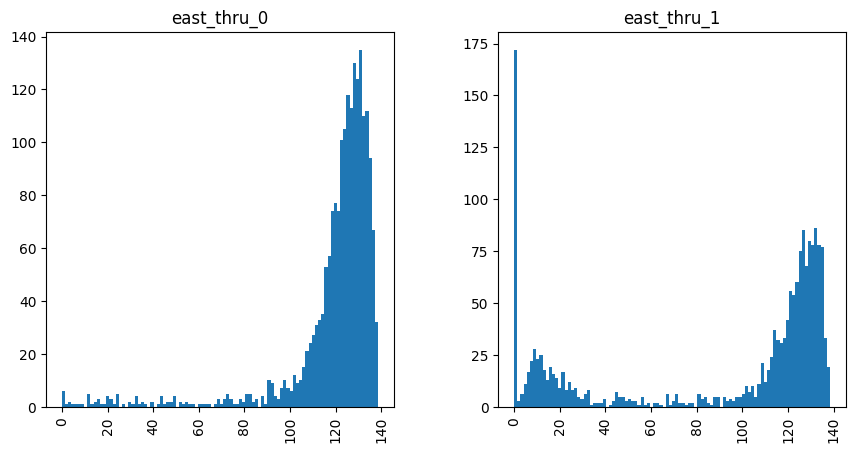

In [20]:
veh_distances.hist(
    column="stop_distance", by="lane", bins=100, figsize=(10, 5), sharex=True
)


In [21]:
from scipy import interpolate

keep_vehicle_ids = veh_distances.loc[
    (veh_distances.stop_distance > 120)
].index.values

lane_0_df = veh_df.loc[(veh_df.lane == lane_0.name) & (veh_df.ui32_objectID.isin(keep_vehicle_ids))]


times = []

measure_distances = [110, 60, 40]

for g, veh in lane_0_df.groupby("ui32_objectID"):

    if (veh.stop_distance.max() < 120) or (veh.stop_distance.min() > 30):
        continue
    
    f = interpolate.interp1d(
        veh.stop_distance,
        veh.dt.astype(int),
        copy=False,
        kind="linear",
    )
    times.extend(
        {
            "veh": g,
            "lane": lane_0.name,
            'distance': x,
            "time": y
        } for x, y in zip(measure_distances, f(measure_distances))
    )



In [23]:
headway_df = pd.DataFrame(times)
headway_df["time"] = pd.to_datetime(headway_df["time"], unit="ns").dt.tz_localize("UTC").dt.tz_convert("US/Central")
headway_df = headway_df.sort_values("time")

In [24]:
leader = None
headway_times = []
headway_df["headway"] = None


for veh in headway_df['veh'].drop_duplicates():
    veh_times = headway_df.loc[headway_df.veh == veh].copy()
    if leader is None:
        leader = veh_times
        continue
    
    veh_times["headway"] = veh_times.time.values - leader.time.values
    veh_times["headway"] = veh_times["headway"].dt.total_seconds()
    veh_times['leader'] = leader.veh.values
    headway_times.append(veh_times.copy())
    leader = veh_times.copy()
timed_headway_df = pd.concat(headway_times)

In [25]:
timed_headway_df.loc[timed_headway_df.headway < 0].shape, timed_headway_df.shape

((2, 6), (4125, 6))

In [26]:
timed_headway_df = timed_headway_df.loc[timed_headway_df.headway > 0]

In [29]:
dist = timed_headway_df.groupby(["veh"])['headway'].agg(['mean', ]).reset_index()

Text(0.5, 0, 'Headway (s)')

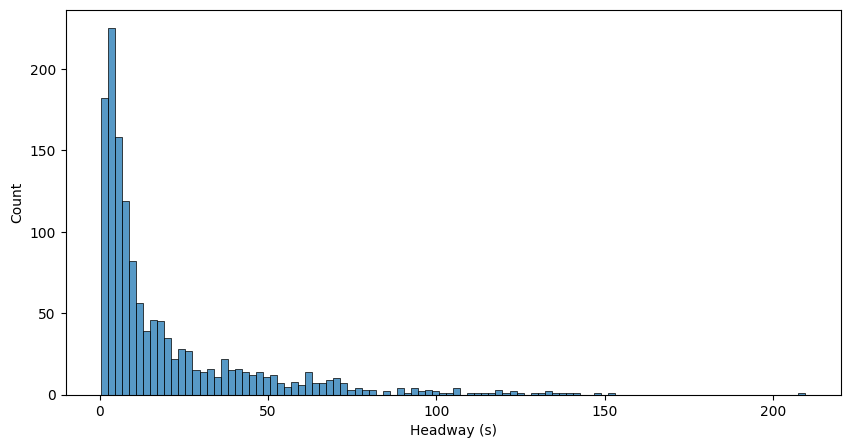

In [30]:
import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

sns.histplot(dist, x="mean", bins=100)

plt.xlabel("Headway (s)")

Text(0.5, 0, 'Headway (s)')

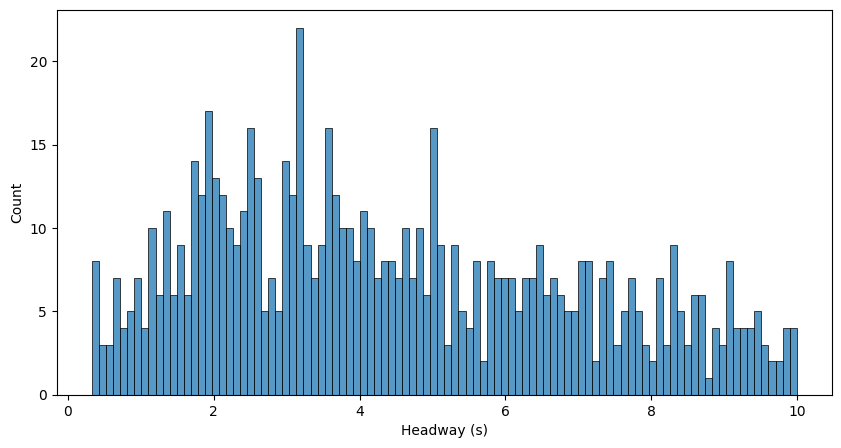

In [31]:
plt.figure(figsize=(10, 5))

sns.histplot(dist.loc[dist['mean'] < 10], x="mean", bins=100)

plt.xlabel("Headway (s)")

In [32]:
# # plot the two vehicle velocities with plotly

# import plotly.graph_objects as go

# fig = go.Figure()

# for veh_df in plot_dfs:
#     fig.add_scatter(
#         x=veh_df.dt,
#         y=veh_df.stop_distance,
#         name=f"{veh_df.ui32_objectID.iloc[0]}",
#         mode="lines",
#     )


# # reverse the y axis
# fig.update_yaxes(autorange="reversed")

# fig.show()


In [ ]:
# ### Calculate the distance to the stopbar, which can be used to find the time headway
# def calc_stopbar_distance(
#     df,
#     approach: ApproachInfo,
#     inbox: bool = True,
# ):
#     df["stopbar_distance"] = 0
#     df["stopbar_distance"] = df[["f32_positionX_m", "f32_positionY_m"]].apply(
#         lambda x: np.linalg.norm(x - approach.end_point), axis=1
#     )
#     return df


# veh_groups = lane_0_df.groupby("ui32_objectID")
# lane_0_df = veh_groups.apply(calc_stopbar_distance, approach=lane_0, inbox=True)
# # veh_groups = lane_0_df.groupby("ui32_objectID")


/var/folders/96/_9h8bqbx4gqcmb4td8q57q8w0000gn/T/ipykernel_25394/3786753108.py:15: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



In [107]:
i = 0
for g, veh_df in radars[0].df[radars[0].df.box.str.contains("East thru")].groupby("ui32_objectID"):
    if i >= 679:
        break
    i += 1

In [108]:
from math import ceil
import numpy as np
from scipy import linalg


def lowess(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for _ in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest




In [116]:
# plot the results
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# create a figure with a secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

smoothed = lowess((veh_df.dt - veh_df.dt.min()).dt.total_seconds().values, veh_df["f32_velocityInDir_mps"].values, f=1/3, iter=2)

# calculate the instantaneous acceleration
accel = np.diff(smoothed) / np.diff((veh_df.dt - veh_df.dt.min()).dt.total_seconds().values)
raw_accel = np.diff(veh_df["f32_velocityInDir_mps"].values) / np.diff((veh_df.dt - veh_df.dt.min()).dt.total_seconds().values)

fig.add_scatter(
    x=(veh_df.dt - veh_df.dt.min()).dt.total_seconds().values,
    y=smoothed,
    name="velocity - Lowess",
    mode="lines",
)

fig.add_scatter(
    x=(veh_df.dt - veh_df.dt.min()).dt.total_seconds().values,
    y=veh_df["f32_velocityInDir_mps"].values,
    name="velocity True",
    mode="lines",
)

fig.add_scatter(
    x=(veh_df.dt - veh_df.dt.min()).dt.total_seconds().values[1:],
    y=accel,
    name="acceleration - Lowess",
    mode="lines",
    secondary_y=True,
) 

fig.add_scatter(
    x=(veh_df.dt - veh_df.dt.min()).dt.total_seconds().values[1:],
    y=raw_accel,
    name="acceleration 'true'",
    mode="lines",
    secondary_y=True,
)

## Geo Plot the Radars


In [117]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

mapbox_key = "pk.eyJ1IjoibWF4LXNjaHJhZGVyIiwiYSI6ImNrOHQxZ2s3bDAwdXQzbG81NjZpZm96bDEifQ.etUi4OK4ozzaP_P8foZn_A"
fig = go.Figure()

for r in radars:
    # r.theta = 297
    # r._create_rotation()
    # r.radar_xy_2_latlon()
    _s = r.df.sample(10000)
    fig.add_trace(
        go.Scattermapbox(
            lon=_s["lon"],
            lat=_s["lat"],
            mode="markers",
            opacity=1,
            line_width=4,
            name=r.name,
        )
    )

# r = radars[0]
# r._create_rotation()
# r.radar_xy_2_latlon()
# _s = r.df.sample(10000)
# fig.add_trace(
#     go.Scattermapbox(
#         lon=_s["lon"],
#         lat=_s["lat"],
#         mode="markers",
#         opacity=1,
#         line_width=4,
#         name=r.name,
#     )
# )

fig.update_layout(template="ggplot2", height=600, width=1200, font_size=18)

fig.update_layout(
    margin=go.layout.Margin(
        l=50,  # left margin
        r=50,  # right margin
        b=50,  # bottom margin
        t=50,  # top margin
    ),
    mapbox=dict(
        accesstoken=mapbox_key,
        bearing=0,
        style="mapbox://styles/mapbox/satellite-v9",
        center=go.layout.mapbox.Center(lat=_s["lat"].mean(), lon=_s["lon"].mean()),
        pitch=0,
        zoom=14.1,
    ),
)


fig.show()


In [ ]:
fig = go.Figure()

sample_df = radars[0].df.sample(10000)
for name, approach in radars[0].approaches:
    fig.add_trace(
        go.Scatter(
            x=[x for x, y in approach.polygon.exterior.coords],
            y=[y for x, y in approach.polygon.exterior.coords],
            name=name,
        )
    )

    filterer = sample_df["box"] == name

    fig.add_trace(
        go.Scatter(
            x=sample_df.loc[filterer, "f32_positionX_m"],
            y=sample_df.loc[filterer, "f32_positionY_m"],
            mode="markers",
            name=f"{name} points",
        )
    )

for approach in [lane_0, lane_1]:
    fig.add_trace(
        go.Scatter(
            x=[x for x, y in approach.polygon.exterior.coords],
            y=[y for x, y in approach.polygon.exterior.coords],
            name=approach.name,
        )
    )

    # filterer = sample_df["lane"] == approach.name

    # fig.add_trace(
    #     go.Scatter(
    #         x=sample_df.loc[filterer, "f32_positionX_m"],
    #         y=sample_df.loc[filterer, "f32_positionY_m"],
    #         mode="markers",
    #         name=f"{approach.name} points",
    #     )
    # )


# # add a dot at the end of the approach
# fig.add_trace(
#     go.Scatter(
#         x=[lane_0.end_point[0]],
#         y=[lane_0.end_point[1]],
#         mode="markers",
#         name="end point",
#     )
# )

fig.update_layout(
    height=600,
)


In [ ]:
list(lane_0.short_sides[0].interpolate(0.5, normalized=True).coords)


[(-11.099057663174126, 27.379494126551652)]

### Time Space Mean Speed


In [ ]:
# filter out the cars that slow down
# r = radars[0]
# min_speed = 5
# maximum_diff = 5


# veh_groups = r.df.groupby("ui32_objectID")
# diff = (
#   veh_groups["f32_velocityInDir_mps"].max()
#  - veh_groups["f32_velocityInDir_mps"].min()
# )
# valid_ids = (
#   veh_groups["f32_velocityInDir_mps"]
#  .max()
# .index[
#    (diff < maximum_diff) & (veh_groups["f32_velocityInDir_mps"].min() > min_speed)
# ]
# .values
# )
# valid_id_filter = r.df.ui32_objectID.isin(valid_ids)


In [ ]:
# veh_groups = (
#  radars[0]
# .df.loc[(radars[0].df["box"] == "West thru") & valid_id_filter]
# .groupby("ui32_objectID")
# .aggregate({"f32_velocityInDir_mps": "mean", "dt": "mean"})
# )


### Plot the Average Speed


In [ ]:
# fig = go.Figure()
# fig_vol = go.Figure()

# resample_period = "300S"
# min_speed = 5
# maximum_diff = 5


# for r in radars:
# filer the vehicles that slowdown out
#    veh_groups = r.df.groupby("ui32_objectID")
#    diff = (
#        veh_groups["f32_velocityInDir_mps"].max()
#       - veh_groups["f32_velocityInDir_mps"].min()
#  )
#  valid_ids = (
#     veh_groups["f32_velocityInDir_mps"]
#    .max()
#    .index[
#       (diff < maximum_diff)
#      & (veh_groups["f32_velocityInDir_mps"].min() > min_speed)
# ]
# .values
# )
# valid_id_filter = r.df.ui32_objectID.isin(valid_ids)

# for filt in [True, False]:
#     for name, approach in r:
#        if "dep" in name:
#
#               local_df = (
#                  r.df.loc[(r.df["box"] == approach.name) & valid_id_filter].copy()
#                 if filt
#                else r.df.loc[r.df["box"] == approach.name].copy()
#   )

#           resampler = local_df.set_index("dt").resample(resample_period)
#          velo_df = resampler.mean()
#         count_df = resampler.nunique()

# original method

#        fig.add_trace(
#           go.Scatter(
#              x=velo_df.index,
#             y=velo_df["f32_velocityInDir_mps"] * 2.236936,
#            name=approach.name + ("- filt" if filt else ""),
#       )
#  )

#  fig_vol.add_trace(
#     go.Scatter(
#        x=count_df["ui32_objectID"].values,
#       y=(velo_df["f32_velocityInDir_mps"] * 2.236936).values,
#      name=approach.name + ("- filt" if filt else ""),
#     mode="markers",
#    hovertemplate="%{text}",
#   text=[f"{dt}" for dt in count_df.index],
# )
# )

# group by vehicle id and then set the index to datetime and sort
#  zone_groups = (
#     local_df.groupby("ui32_objectID")
#    .aggregate(
#       {
#          "f32_velocityInDir_mps": "mean",
#         "dt": "mean",
#    }
# )
# .set_index("dt")
# .sort_index()
# )
# veh_avg = zone_groups.resample(resample_period).mean()
# veh_counts = zone_groups.resample(resample_period).count()

# .resample(resample_period).mean()
# fig.add_trace(
#   go.Scatter(
#      x=veh_avg.index,
#     y=veh_avg["f32_velocityInDir_mps"] * 2.236936,
#    name=approach.name + ("- filt" if filt else "") + "- veh avg",
#  )
# )

# fig_vol.add_trace(
#    go.Scatter(
#       x=veh_counts["f32_velocityInDir_mps"],
#      y=veh_avg["f32_velocityInDir_mps"] * 2.236936,
#     name=approach.name + ("- filt" if filt else "") + "- veh avg",
#    mode="markers",
#   hovertemplate="%{text}",
#  # text=[f"{dt}" for dt in count_df.index],
# )
# )


In [ ]:
# fig.show()
# fig_vol.show()


### Remove "Stopped Vehicles"


In [ ]:
# radars[0].df


In [ ]:
# BEGIN = datetime.strptime("2022-05-24 09:20:23", "%Y-%m-%d %H:%M:%S")
# END = datetime.strptime("2022-05-24 09:30:23", "%Y-%m-%d %H:%M:%S")

# time_slice = (radars[0].df["dt"] > BEGIN) & (radars[0].df["dt"] < END)
# light_time_slice = (radars[0].df.dt > BEGIN) & (
#   radars[0].df.dt < END
# )

# veh_groups = radars[0].df.loc[time_slice].groupby("ui32_objectID")


### Calculate the Distance to the Stopline


In [ ]:
# -def calc_stopbar_distance(
#   df,
#  approach: Tuple[str, ApproachInfo],
# inbox: bool = True,
# ):
#   slicer = df["box"] == approach[0] if inbox else [True] * len(df)
#  df["stopbar_distance"] = 0
# df.loc[slicer, "stopbar_distance"] = df.loc[
#    slicer, ["f32_positionX_m", "f32_positionY_m"]
# ].apply(lambda x: np.linalg.norm(x - approach[1].end_point), axis=1)
# return df
# df.loc[slicer, 'stopbar_distance'] = \
#     (df.loc[slicer, ['f32_positionX_m', 'f32_positionY_m']] - df.loc[slicer, ['f32_positionX_m', 'f32_positionY_m']].shift(1).fillna(method='bfill'))[['f32_positionX_m', 'f32_positionY_m']].apply(lambda x: np.linalg.norm(x), axis=1).cumsum()
# return df


# veh_df = veh_groups.apply(
#   calc_stopbar_distance, approach=radars[0].approaches[0], inbox=True
# )
# veh_groups = veh_df.groupby("ui32_objectID")


In [ ]:
# veh_df


### Calculate if the Vehicle Passes Completely Through the Polygon


In [ ]:
# def passes_through_polygon(df, approach: Tuple[str, ApproachInfo]):
#   if (df["box"] == approach[0]).any():
#      try:
#         return approach[1].check_complete_pass(
#            LineString(df[["f32_positionX_m", "f32_positionY_m"]].values)
#       )
#  except ValueError:
#     return False
# return False


# veh_groups = veh_df.groupby("ui32_objectID")

# pass_thru_ids = veh_groups.apply(
#   passes_through_polygon, approach=radars[0].approaches[0]
# )


In [ ]:
veh_df = radars[0].df.copy()


In [ ]:
# we want to start with processing the east thru vehicles
east_thru = radars[0].approaches[0]


In [ ]:
# we want to start with processing the east thru vehicles
# explain this function
# we use the approach name to filter the dataframe to only the vehicles that are in the approach
def passes_through_polygon(df, approach: Tuple[str, ApproachInfo]):
    if (df["box"] == approach[0]).any():
        if len(df) < 2:
            return False
        try:
            return approach[1].check_complete_pass(
                LineString(df[["f32_positionX_m", "f32_positionY_m"]].values)
            )
        except ValueError:
            return False
    return False


veh_groups = veh_df.groupby("ui32_objectID")
pass_thru_ids = veh_groups.apply(passes_through_polygon, approach=east_thru)


In [ ]:
# now we want to filter out the vehicles that don't pass through the polygon
# explain this line
# we use the index of the pass_thru_ids series to filter the veh_df dataframe
pass_thru_ids = pass_thru_ids.loc[pass_thru_ids]
print(veh_df.shape[0])
veh_df = veh_df.loc[veh_df["ui32_objectID"].isin(pass_thru_ids.index)].reset_index(
    drop=True
)
print(veh_df.shape[0])


2587781
521453


In [ ]:
# sharply divide the east thru line into 2 sections
# divide the line into 2 sections


### Calculate Vehicle Distance Traveled


In [ ]:
# def calc_cum_distance(
#   df,
#  box_name: str,
# inbox: bool = True,
# ):
#   slicer = df["box"] == box_name if inbox else [True] * len(df)
#  df["cum_distance"] = 0
# df.loc[slicer, "cum_distance"] = (
#    (
#       df.loc[slicer, ["f32_positionX_m", "f32_positionY_m"]]
#      - df.loc[slicer, ["f32_positionX_m", "f32_positionY_m"]]
#     .shift(1)
#    .fillna(method="bfill")
# )[["f32_positionX_m", "f32_positionY_m"]]
# .apply(lambda x: np.linalg.norm(x), axis=1)
# .cumsum()
# )
# return df


# this returns a dataframe with the cumulative distance for each vehicle
# veh_df = veh_groups.apply(
#   calc_cum_distance, box_name=radars[0].approaches[0][0], inbox=True
# )
# veh_groups = veh_df.groupby("ui32_objectID")


In [ ]:
def calc_cum_distance(
    df,
    box_name: str,
    inbox: bool = True,
):
    slicer = df["box"] == box_name if inbox else [True] * len(df)
    df["cum_distance"] = 0
    df.loc[slicer, "cum_distance"] = (
        (
            df.loc[slicer, ["f32_positionX_m", "f32_positionY_m"]]
            - df.loc[slicer, ["f32_positionX_m", "f32_positionY_m"]]
            .shift(1)
            .fillna(method="bfill")
        )[["f32_positionX_m", "f32_positionY_m"]]
        .apply(lambda x: np.linalg.norm(x), axis=1)
        .cumsum()
    )
    return df


# regroup the dataframe
veh_groups = veh_df.groupby("ui32_objectID")
# this returns a dataframe with the cumulative distance for each vehicle
veh_df = veh_groups.apply(calc_cum_distance, box_name=east_thru[0], inbox=True)
veh_groups = veh_df.groupby("ui32_objectID")


/var/folders/96/_9h8bqbx4gqcmb4td8q57q8w0000gn/T/ipykernel_25394/1446379236.py:24: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure()

# for veh_name, veh in [[85291, veh_groups.get_group(85291)]]:
# for veh_name, veh in veh_groups:
# if veh_name == 85134:
#    if (veh["box"] == "East thru").any() & (veh["box"] != "East left").all():

# fig.add_trace(go.Scatter(x=veh["dt"], y=veh["f32_velocityInDir_mps"] * 2.236936, name=veh_name, mode="lines"))
# fig.add_trace(go.Scatter(x=veh["dt"], y=veh["cum_distance"], name=veh_name, mode="lines"))
#        fig.add_trace(
#            go.Scatter(
#                x=veh.loc[veh["box"] == "East thru", "dt"],
#               y=140 - veh.loc[veh["box"] == "East thru", "stopbar_distance"],
#              name=veh_name,
#             mode="lines",
#        )
#   )
# break
# fig.add_trace(go.Scatter(x=veh["dt"], y=veh["ui16_ageCount"], name=veh_name))
# fig.add_trace(go.Scatter(x=veh["dt"], y=veh["f32_trackQuality"], name=veh_name))

# sliced_lights = light_states.loc[
#     (light_states["EventParam"] == 6)
#     & light_time_slice
#     & (light_states["Color"] == "green")
# ]

# for row in sliced_lights.iterrows():
#     fig.add_trace(
#         go.Scatter(
#             x=[row[1]["Timestamp"], row[1]["End_Timestamp"]],
#             y=[140, 140],
#             line_color="green",
#         )
#     )


# fig.show()


In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure()

# for veh_name, veh in [[85291, veh_groups.get_group(85291)]]:
# for veh_name, veh in veh_groups:
#   if veh_name == 79827:
# if (veh["box"] == "West thru").any() & (veh["box"] != "West right").all():
#      veh= veh.loc[veh["box"] == "West thru"]

#     fig.add_trace(go.Scatter(x=veh["dt"], y=veh["f32_velocityInDir_mps"] * 2.236936, name=veh_name, mode="lines"))
#    fig.add_trace(go.Scatter(x=veh["dt"], y=veh["stopbar_distance"], name=veh_name, mode="lines"))
# fig.add_trace(
#     go.Scatter(
#         x=veh.loc[veh["box"] == "West thru", "dt"],
#         y=140 - veh.loc[veh["box"] == "West thru", "stopbar_distance"],
#         name=veh_name,
#         mode="lines",
#     )
# )
# break
# fig.add_trace(go.Scatter(x=veh["dt"], y=veh["ui16_ageCount"], name=veh_name))
# fig.add_trace(go.Scatter(x=veh["dt"], y=veh["f32_trackQuality"], name=veh_name))

# sliced_lights = light_states.loc[
#     (light_states["EventParam"] == 6)
#     & light_time_slice
#     & (light_states["Color"] == "green")
# ]

# for row in sliced_lights.iterrows():
#     fig.add_trace(
#         go.Scatter(
#             x=[row[1]["Timestamp"], row[1]["End_Timestamp"]],
#             y=[140, 140],
#             line_color="green",
#         )
#     )


# fig.show()


In [ ]:
# fig = go.Figure()


# for name, approach in radars[0].approaches:
#   fig.add_trace(
#      go.Scatter(
#         x=[x for x, y in approach.polygon.exterior.coords],
#        y=[y for x, y in approach.polygon.exterior.coords],
#       name=name,
#  )
#  )


# i = 0
# for veh_name, veh in veh_groups:
# if veh_name == 79803:
#   fig.add_trace(go.Scatter(x=veh["f32_positionX_m"], y=veh["f32_positionY_m"], name=veh_name))
#     # break
# i += 1
# if i > 10:
#   break
# fig.show()
# fig.update_layout(height=600, width=600)


In [ ]:
fig = go.Figure()


for name, approach in radars[0].approaches:
    fig.add_trace(
        go.Scatter(
            x=[x for x, y in approach.polygon.exterior.coords],
            y=[y for x, y in approach.polygon.exterior.coords],
            name=name,
        )
    )


i = 0
for veh_name, veh in veh_groups:
    # if veh_name == 79803:
    fig.add_trace(
        go.Scatter(x=veh["f32_positionX_m"], y=veh["f32_positionY_m"], name=veh_name)
    )
    # break
    i += 1
    if i > 10:
        break
fig.show()
# fig.update_layout(height=600, width=600)


In [ ]:
print(veh_df.shape[0])
veh_df = veh_df.loc[veh_df["box"].str.contains(east_thru[0])].reset_index(drop=True)
print(veh_df.shape[0])


521453
302264


CSV Export of the Data for the Radar Analysis


In [ ]:
# put car number.
# car_no=77966
# filter veh_df dataframe by car number.
# veh_n = veh_df[veh_df['ui32_objectID'] == car_no]
# filter veh_n dataframe by column name.
# veh_n = pd.DataFrame(veh_n, columns= ['ui16_predictionCount','f32_positionX_m','f32_positionY_m','f32_velocityInDir_mps','lat','lon','dt'])
# export to csv file.
# veh_n.to_csv('data_'+str(car_no)+'.csv')


In [ ]:
# put car number.
# car_no=77973
# car_no= 77840
# car_no= 77782

# filter veh_df dataframe by car number.
# veh_n1 = veh_df[veh_df['ui32_objectID'] == car_no]
# filter veh_n dataframe by column name.
# veh_n1 = pd.DataFrame(veh_n1, columns= ['ui16_predictionCount','f32_positionX_m','f32_positionY_m','f32_velocityInDir_mps','lat','lon','dt'])
# export to csv file.
# veh_n1.to_csv('data_'+str(car_no)+'.csv')


In [ ]:
# veh_df

# convert veh_df dataframe to csv file.
# veh_df.to_csv('veh_df.csv')


In [ ]:
# veh_df


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


TIME_COL = "relative_time"
SPD_COL = "f32_velocityInDir_mps"
ABS_TIME_COL = "dt"


from src.pwlfer import process_trajectories, classify


veh_df["relative_time"] = veh_df.groupby("ui32_objectID")["dt"].transform(
    lambda x: (x - x.min()).dt.total_seconds()
)
res = process_trajectories(
    veh_df,
    time_col="relative_time",
    speed_col="f32_velocityInDir_mps",
    id_col="ui32_objectID",
    abs_time_col="dt",
    n_jobs=8,
)
summary_df = pd.DataFrame([{**v, **l} for v in res for l in v.pop("line_fits")])


process: 100%|██████████| 4151/4151 [14:14<00:00,  4.86it/s]


In [ ]:
summary_df["type"] = summary_df.apply(classify, axis=1)
summary_df["minimum_time"] = summary_df["end"] - summary_df["start"]


In [ ]:
summary_df.to_parquet(
    ROOT / "data" / "rw_east_thru_summary.parquet",
    **{"coerce_timestamps": "us", "allow_truncated_timestamps": True}
)


In [ ]:
summary_df = pd.read_parquet(
    ROOT / "data" / "rw_east_thru_summary.parquet",
)


### Plot Some of the Results


In [ ]:
import os
import plotly.express as px

n = 1
vehicle_ids = summary_df.loc[(summary_df["slope"] > 1) & (summary_df["r2"] > 0.9)][
    "vehicle_id"
].unique()

veh_df["relative_time"] = veh_df.groupby("ui32_objectID")["dt"].transform(
    lambda x: (x - x.min()).dt.total_seconds()
)


# for loop to plot 100 vehicles
for i in range(n):
    # get the vehicle id
    vehicle_id = vehicle_ids[i]
    # get the line fits
    vehicle_df = summary_df[summary_df["vehicle_id"] == vehicle_id]

    # get the vehicle data
    vehicle_data = veh_df[veh_df["ui32_objectID"] == vehicle_id].copy()

    # create the figure
    fig = px.line(vehicle_data, x="relative_time", y="f32_velocityInDir_mps")

    line_fits = vehicle_df.to_dict(orient="records")

    # loop through the line fits
    for line_fit in line_fits:
        # get the break
        break_ = line_fit["break"]
        # get the slope
        slope = line_fit["slope"]
        # get the r2
        r2 = line_fit["r2"]
        # get the type
        type_ = line_fit["type"]
        # get the mean speed
        y0 = line_fit["y0"]

        # get the min and max time
        min_time = line_fit["start"]
        max_time = line_fit["end"]
        # add the line
        fig.add_scatter(
            x=[min_time, max_time],
            y=[slope * (min_time) + y0, slope * (max_time) + y0],
            mode="lines",
        )
        # add text of the slope to the middle of the line
        fig.add_annotation(
            x=min_time,
            y=(slope * (min_time) + y0) + 2,
            text=f"accel: {slope:.2f} m/s^2<br>r^2: {r2:.2f}<br>type: {type_}<br>speed: {line_fit['speed']:.2f} mps",
            showarrow=False,
            font=dict(size=14),
        )


fig.show()


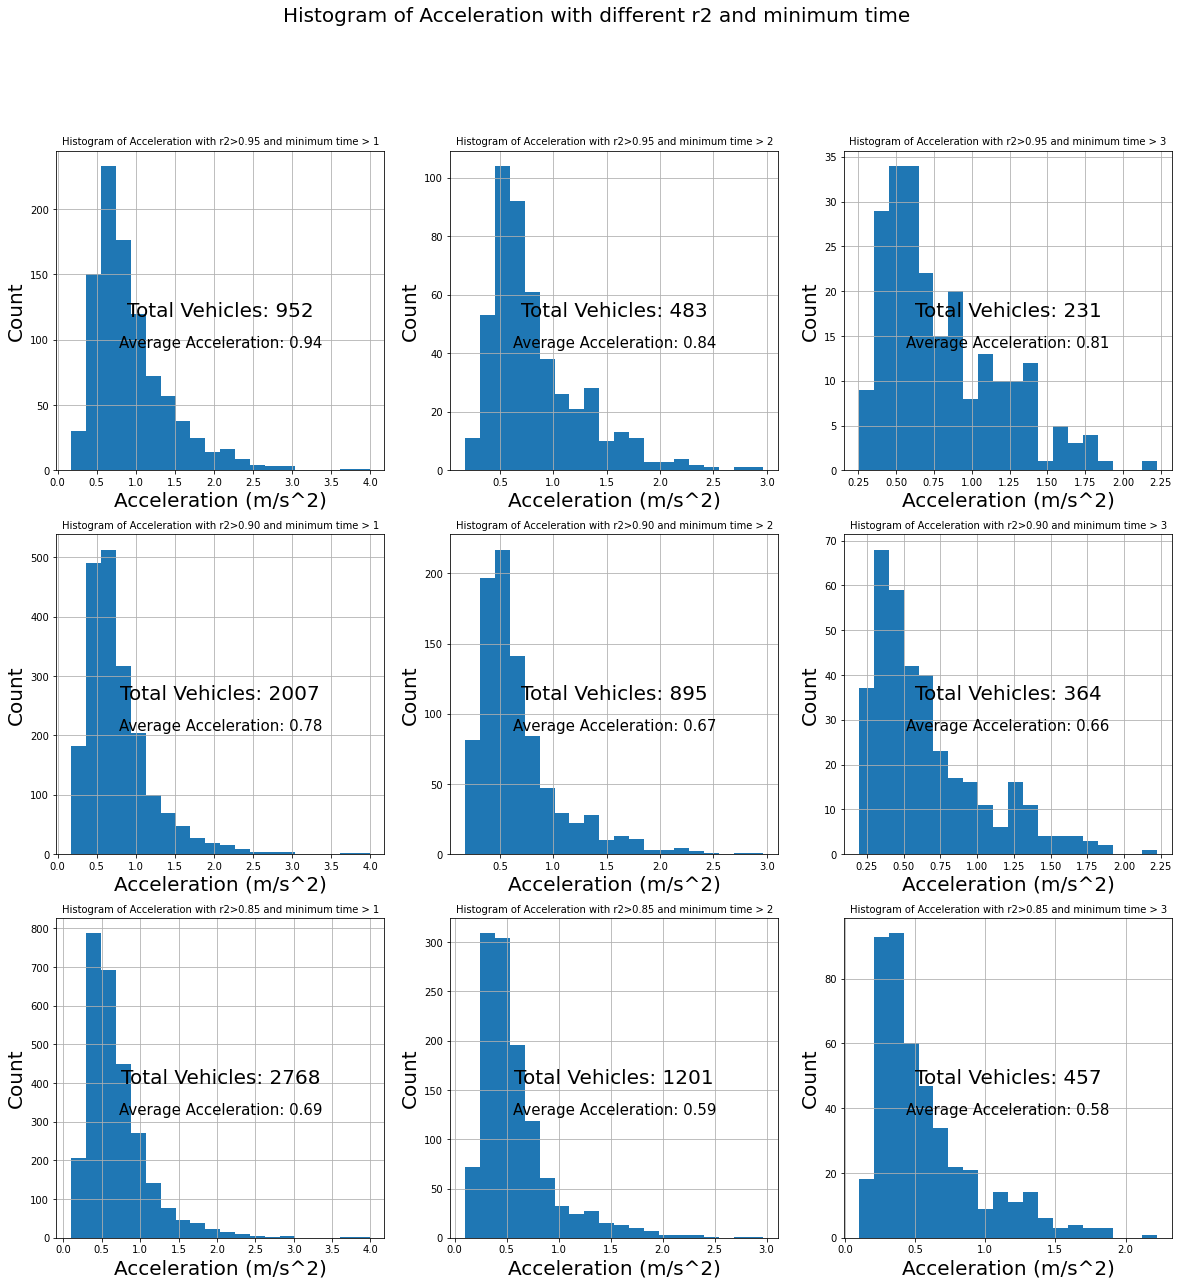

In [ ]:
# make histogram of acceleration 3*3 histogram of acceleration with different r2 and minimum time
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle(
    "Histogram of Acceleration with different r2 and minimum time", fontsize=20
)
# r2>0.95 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.95)
    & (summary_df["minimum_time"] > 1),
    "slope",
].hist(bins=20, ax=axs[0, 0])
axs[0, 0].set_title(
    "Histogram of Acceleration with r2>0.95 and minimum time > 1", fontsize=10
)
axs[0, 0].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[0, 0].set_ylabel("Count", fontsize=20)
axs[0, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 0].transAxes,
    fontsize=20,
)
# axs[0,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .95) & (summary_df['minimum_time'] > 1), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[0,0].legend()
# write average acceleration on the graph with accuracy of actual value
axs[0, 0].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 0].transAxes,
    fontsize=15,
)

# r2>0.95 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.95)
    & (summary_df["minimum_time"] > 2),
    "slope",
].hist(bins=20, ax=axs[0, 1])
axs[0, 1].set_title(
    "Histogram of Acceleration with r2>0.95 and minimum time > 2", fontsize=10
)
axs[0, 1].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[0, 1].set_ylabel("Count", fontsize=20)
axs[0, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 1].transAxes,
    fontsize=20,
)
# write average acceleration on the graph with accuracy of actual value
axs[0, 1].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 1].transAxes,
    fontsize=15,
)
# r2>0.95 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.95)
    & (summary_df["minimum_time"] > 3),
    "slope",
].hist(bins=20, ax=axs[0, 2])
axs[0, 2].set_title(
    "Histogram of Acceleration with r2>0.95 and minimum time > 3", fontsize=10
)
axs[0, 2].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[0, 2].set_ylabel("Count", fontsize=20)
axs[0, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 2].transAxes,
    fontsize=20,
)
# axs[0,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .95) & (summary_df['minimum_time'] > 3), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[0,2].legend()
# write average acceleration on the graph with accuracy of actual value
axs[0, 2].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 2].transAxes,
    fontsize=15,
)
# axs[0,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .95) & (summary_df['minimum_time'] > 3), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[0,2].legend()
# axs[0,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .95) & (summary_df['minimum_time'] > 3), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[0,2].legend()
# r2>0.90 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.90)
    & (summary_df["minimum_time"] > 1),
    "slope",
].hist(bins=20, ax=axs[1, 0])
axs[1, 0].set_title(
    "Histogram of Acceleration with r2>0.90 and minimum time > 1", fontsize=10
)
axs[1, 0].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[1, 0].set_ylabel("Count", fontsize=20)
axs[1, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.90)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 0].transAxes,
    fontsize=20,
)
# axs[1,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 1), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[1,0].legend()
# write average acceleration on the graph with accuracy of actual value
axs[1, 0].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.90)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 0].transAxes,
    fontsize=15,
)

# axs[1,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 1), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[1,0].legend()
# axs[1,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 1), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[1,0].legend()
# r2>0.90 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.90)
    & (summary_df["minimum_time"] > 2),
    "slope",
].hist(bins=20, ax=axs[1, 1])
axs[1, 1].set_title(
    "Histogram of Acceleration with r2>0.90 and minimum time > 2", fontsize=10
)
axs[1, 1].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[1, 1].set_ylabel("Count", fontsize=20)
axs[1, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.90)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 1].transAxes,
    fontsize=20,
)
# axs[1,1].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 2), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[1,1].legend()
# write average acceleration on the graph with accuracy of actual value
axs[1, 1].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.90)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 1].transAxes,
    fontsize=15,
)
# axs[1,1].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 2), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[1,1].legend()
# axs[1,1].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 2), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[1,1].legend()
# r2>0.90 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.90)
    & (summary_df["minimum_time"] > 3),
    "slope",
].hist(bins=20, ax=axs[1, 2])
axs[1, 2].set_title(
    "Histogram of Acceleration with r2>0.90 and minimum time > 3", fontsize=10
)
axs[1, 2].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[1, 2].set_ylabel("Count", fontsize=20)
axs[1, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.90)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 2].transAxes,
    fontsize=20,
)
# axs[1,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 3), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[1,2].legend()
# write average acceleration on the graph with accuracy of actual value
axs[1, 2].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.90)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 2].transAxes,
    fontsize=15,
)
# axs[1,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 3), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[1,2].legend()
# axs[1,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 3), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[1,2].legend()
# r2>0.85 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.85)
    & (summary_df["minimum_time"] > 1),
    "slope",
].hist(bins=20, ax=axs[2, 0])
axs[2, 0].set_title(
    "Histogram of Acceleration with r2>0.85 and minimum time > 1", fontsize=10
)
axs[2, 0].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[2, 0].set_ylabel("Count", fontsize=20)
axs[2, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 0].transAxes,
    fontsize=20,
)
# axs[2,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 1), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[2,0].legend()
# write average acceleration on the graph with accuracy of actual value
axs[2, 0].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 0].transAxes,
    fontsize=15,
)

# axs[2,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 1), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[2,0].legend()
# axs[2,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 1), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[2,0].legend()
# r2>0.85 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.85)
    & (summary_df["minimum_time"] > 2),
    "slope",
].hist(bins=20, ax=axs[2, 1])
axs[2, 1].set_title(
    "Histogram of Acceleration with r2>0.85 and minimum time > 2", fontsize=10
)
axs[2, 1].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[2, 1].set_ylabel("Count", fontsize=20)
axs[2, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 1].transAxes,
    fontsize=20,
)
# axs[2,1].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 2), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[2,1].legend()
# write average acceleration on the graph with accuracy of actual value
axs[2, 1].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 1].transAxes,
    fontsize=15,
)
# axs[2,1].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 2), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[2,1].legend()
# axs[2,1].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 2), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[2,1].legend()
# r2>0.85 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.85)
    & (summary_df["minimum_time"] > 3),
    "slope",
].hist(bins=20, ax=axs[2, 2])
axs[2, 2].set_title(
    "Histogram of Acceleration with r2>0.85 and minimum time > 3", fontsize=10
)
axs[2, 2].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[2, 2].set_ylabel("Count", fontsize=20)
axs[2, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 2].transAxes,
    fontsize=20,
)
# axs[2,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 3), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[2,2].legend()
# write average acceleration on the graph with accuracy of actual value
axs[2, 2].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 2].transAxes,
    fontsize=15,
)

# axs[2,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 3), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[2,2].legend()
# axs[2,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 3), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[2,2].legend()
plt.show()


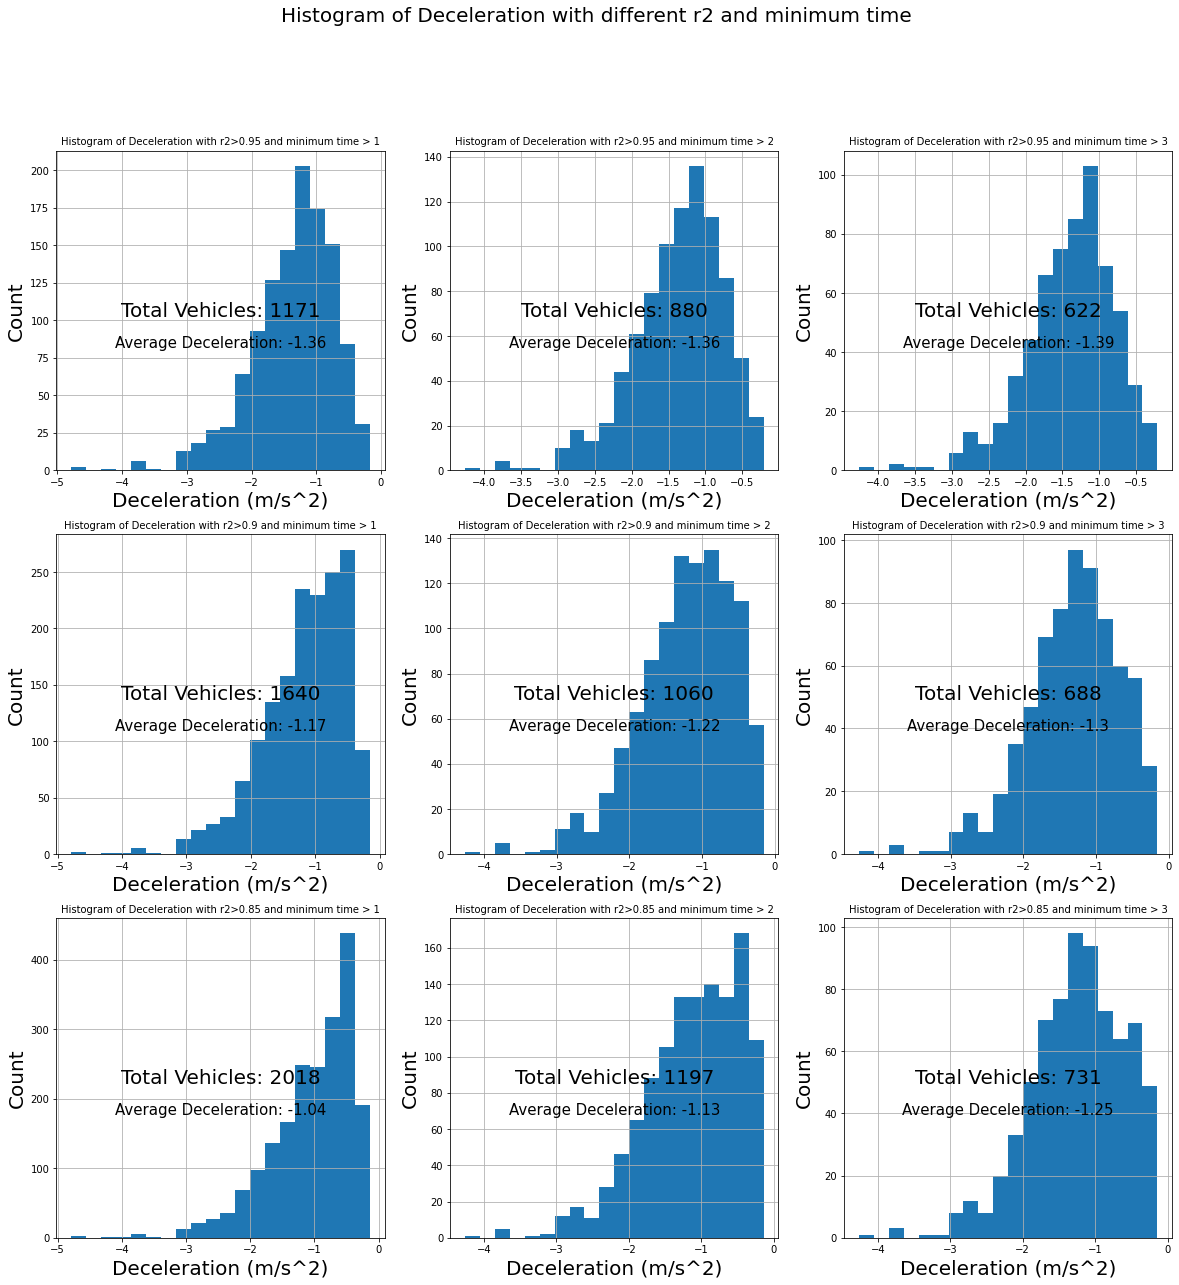

In [ ]:
# #make histogram of decelration 3*3 histogram of decelration with different r2 and minimum time
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle(
    "Histogram of Deceleration with different r2 and minimum time", fontsize=20
)
# r2>0.95 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("decel"))
    & (summary_df["r2"] > 0.95)
    & (summary_df["minimum_time"] > 1),
    "slope",
].hist(bins=20, ax=axs[0, 0])
axs[0, 0].set_title(
    "Histogram of Deceleration with r2>0.95 and minimum time > 1", fontsize=10
)
axs[0, 0].set_xlabel("Deceleration (m/s^2)", fontsize=20)
axs[0, 0].set_ylabel("Count", fontsize=20)
axs[0, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 0].transAxes,
    fontsize=20,
)
# write average deceleration on the graph with accuracy of actual value
axs[0, 0].text(
    0.5,
    0.4,
    "Average Deceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 0].transAxes,
    fontsize=15,
)

# r2>0.95 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("decel"))
    & (summary_df["r2"] > 0.95)
    & (summary_df["minimum_time"] > 2),
    "slope",
].hist(bins=20, ax=axs[0, 1])
axs[0, 1].set_title(
    "Histogram of Deceleration with r2>0.95 and minimum time > 2", fontsize=10
)
axs[0, 1].set_xlabel("Deceleration (m/s^2)", fontsize=20)
axs[0, 1].set_ylabel("Count", fontsize=20)
axs[0, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 1].transAxes,
    fontsize=20,
)
# write average deceleration on the graph with accuracy of actual value
axs[0, 1].text(
    0.5,
    0.4,
    "Average Deceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 1].transAxes,
    fontsize=15,
)

# r2>0.95 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("decel"))
    & (summary_df["r2"] > 0.95)
    & (summary_df["minimum_time"] > 3),
    "slope",
].hist(bins=20, ax=axs[0, 2])
axs[0, 2].set_title(
    "Histogram of Deceleration with r2>0.95 and minimum time > 3", fontsize=10
)
axs[0, 2].set_xlabel("Deceleration (m/s^2)", fontsize=20)
axs[0, 2].set_ylabel("Count", fontsize=20)
axs[0, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 2].transAxes,
    fontsize=20,
)
# write average deceleration on the graph with accuracy of actual value
axs[0, 2].text(
    0.5,
    0.4,
    "Average Deceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 2].transAxes,
    fontsize=15,
)

# r2>0.9 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("decel"))
    & (summary_df["r2"] > 0.9)
    & (summary_df["minimum_time"] > 1),
    "slope",
].hist(bins=20, ax=axs[1, 0])
axs[1, 0].set_title(
    "Histogram of Deceleration with r2>0.9 and minimum time > 1", fontsize=10
)
axs[1, 0].set_xlabel("Deceleration (m/s^2)", fontsize=20)
axs[1, 0].set_ylabel("Count", fontsize=20)
axs[1, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.9)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 0].transAxes,
    fontsize=20,
)
# write average deceleration on the graph with accuracy of actual value
axs[1, 0].text(
    0.5,
    0.4,
    "Average Deceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.9)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 0].transAxes,
    fontsize=15,
)

# r2>0.9 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("decel"))
    & (summary_df["r2"] > 0.9)
    & (summary_df["minimum_time"] > 2),
    "slope",
].hist(bins=20, ax=axs[1, 1])
axs[1, 1].set_title(
    "Histogram of Deceleration with r2>0.9 and minimum time > 2", fontsize=10
)
axs[1, 1].set_xlabel("Deceleration (m/s^2)", fontsize=20)
axs[1, 1].set_ylabel("Count", fontsize=20)
axs[1, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.9)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 1].transAxes,
    fontsize=20,
)
# write average deceleration on the graph with accuracy of actual value
axs[1, 1].text(
    0.5,
    0.4,
    "Average Deceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.9)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 1].transAxes,
    fontsize=15,
)

# r2>0.9 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("decel"))
    & (summary_df["r2"] > 0.9)
    & (summary_df["minimum_time"] > 3),
    "slope",
].hist(bins=20, ax=axs[1, 2])
axs[1, 2].set_title(
    "Histogram of Deceleration with r2>0.9 and minimum time > 3", fontsize=10
)
axs[1, 2].set_xlabel("Deceleration (m/s^2)", fontsize=20)
axs[1, 2].set_ylabel("Count", fontsize=20)
axs[1, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.9)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 2].transAxes,
    fontsize=20,
)
# write average deceleration on the graph with accuracy of actual value
axs[1, 2].text(
    0.5,
    0.4,
    "Average Deceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.9)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 2].transAxes,
    fontsize=15,
)

# r2>0.85 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("decel"))
    & (summary_df["r2"] > 0.85)
    & (summary_df["minimum_time"] > 1),
    "slope",
].hist(bins=20, ax=axs[2, 0])
axs[2, 0].set_title(
    "Histogram of Deceleration with r2>0.85 and minimum time > 1", fontsize=10
)
axs[2, 0].set_xlabel("Deceleration (m/s^2)", fontsize=20)
axs[2, 0].set_ylabel("Count", fontsize=20)
axs[2, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 0].transAxes,
    fontsize=20,
)
# write average deceleration on the graph with accuracy of actual value
axs[2, 0].text(
    0.5,
    0.4,
    "Average Deceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 0].transAxes,
    fontsize=15,
)

# r2>0.85 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("decel"))
    & (summary_df["r2"] > 0.85)
    & (summary_df["minimum_time"] > 2),
    "slope",
].hist(bins=20, ax=axs[2, 1])
axs[2, 1].set_title(
    "Histogram of Deceleration with r2>0.85 and minimum time > 2", fontsize=10
)
axs[2, 1].set_xlabel("Deceleration (m/s^2)", fontsize=20)
axs[2, 1].set_ylabel("Count", fontsize=20)
axs[2, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 1].transAxes,
    fontsize=20,
)
# write average deceleration on the graph with accuracy of actual value
axs[2, 1].text(
    0.5,
    0.4,
    "Average Deceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 1].transAxes,
    fontsize=15,
)

# r2>0.85 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("decel"))
    & (summary_df["r2"] > 0.85)
    & (summary_df["minimum_time"] > 3),
    "slope",
].hist(bins=20, ax=axs[2, 2])
axs[2, 2].set_title(
    "Histogram of Deceleration with r2>0.85 and minimum time > 3", fontsize=10
)
axs[2, 2].set_xlabel("Deceleration (m/s^2)", fontsize=20)
axs[2, 2].set_ylabel("Count", fontsize=20)
axs[2, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 2].transAxes,
    fontsize=20,
)
# write average deceleration on the graph with accuracy of actual value
axs[2, 2].text(
    0.5,
    0.4,
    "Average Deceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 2].transAxes,
    fontsize=15,
)

plt.show()


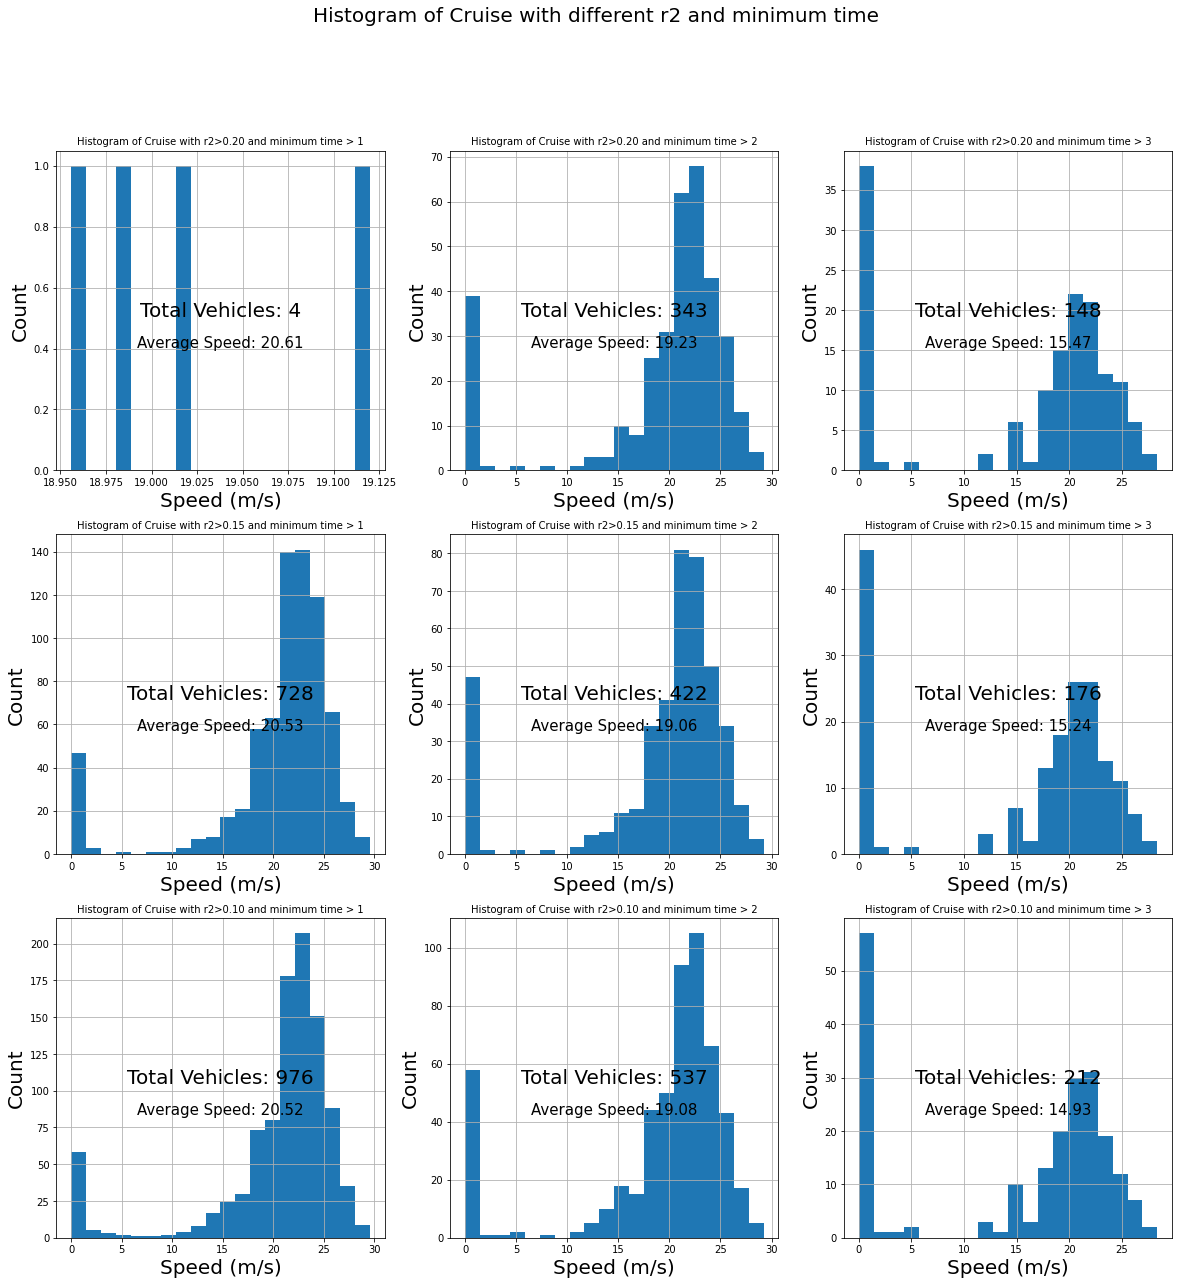

In [ ]:
# histogram of cruise , speed

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle("Histogram of Cruise with different r2 and minimum time", fontsize=20)

# r2>0.20 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("cruise"))
    & (summary_df["r2"] > 0.80)
    & (summary_df["minimum_time"] > 1),
    "speed",
].hist(bins=20, ax=axs[0, 0])
axs[0, 0].set_title(
    "Histogram of Cruise with r2>0.20 and minimum time > 1", fontsize=10
)
axs[0, 0].set_xlabel("Speed (m/s)", fontsize=20)
axs[0, 0].set_ylabel("Count", fontsize=20)
axs[0, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.80)
                & (summary_df["minimum_time"] > 1),
                "speed",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 0].transAxes,
    fontsize=20,
)
# write average speed on the graph with accuracy of actual value
axs[0, 0].text(
    0.5,
    0.4,
    "Average Speed: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.20)
                & (summary_df["minimum_time"] > 1),
                "speed",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 0].transAxes,
    fontsize=15,
)

# r2>0.20 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("cruise"))
    & (summary_df["r2"] > 0.20)
    & (summary_df["minimum_time"] > 2),
    "speed",
].hist(bins=20, ax=axs[0, 1])
axs[0, 1].set_title(
    "Histogram of Cruise with r2>0.20 and minimum time > 2", fontsize=10
)
axs[0, 1].set_xlabel("Speed (m/s)", fontsize=20)
axs[0, 1].set_ylabel("Count", fontsize=20)
axs[0, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.20)
                & (summary_df["minimum_time"] > 2),
                "speed",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 1].transAxes,
    fontsize=20,
)
# write average speed on the graph with accuracy of actual value
axs[0, 1].text(
    0.5,
    0.4,
    "Average Speed: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.20)
                & (summary_df["minimum_time"] > 2),
                "speed",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 1].transAxes,
    fontsize=15,
)

# r2>0.20 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("cruise"))
    & (summary_df["r2"] > 0.20)
    & (summary_df["minimum_time"] > 3),
    "speed",
].hist(bins=20, ax=axs[0, 2])
axs[0, 2].set_title(
    "Histogram of Cruise with r2>0.20 and minimum time > 3", fontsize=10
)
axs[0, 2].set_xlabel("Speed (m/s)", fontsize=20)
axs[0, 2].set_ylabel("Count", fontsize=20)
axs[0, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.20)
                & (summary_df["minimum_time"] > 3),
                "speed",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 2].transAxes,
    fontsize=20,
)
# write average speed on the graph with accuracy of actual value
axs[0, 2].text(
    0.5,
    0.4,
    "Average Speed: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.20)
                & (summary_df["minimum_time"] > 3),
                "speed",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 2].transAxes,
    fontsize=15,
)

# r2>0.15 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("cruise"))
    & (summary_df["r2"] > 0.15)
    & (summary_df["minimum_time"] > 1),
    "speed",
].hist(bins=20, ax=axs[1, 0])
axs[1, 0].set_title(
    "Histogram of Cruise with r2>0.15 and minimum time > 1", fontsize=10
)
axs[1, 0].set_xlabel("Speed (m/s)", fontsize=20)
axs[1, 0].set_ylabel("Count", fontsize=20)
axs[1, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.15)
                & (summary_df["minimum_time"] > 1),
                "speed",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 0].transAxes,
    fontsize=20,
)
# write average speed on the graph with accuracy of actual value
axs[1, 0].text(
    0.5,
    0.4,
    "Average Speed: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.15)
                & (summary_df["minimum_time"] > 1),
                "speed",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 0].transAxes,
    fontsize=15,
)

# r2>0.15 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("cruise"))
    & (summary_df["r2"] > 0.15)
    & (summary_df["minimum_time"] > 2),
    "speed",
].hist(bins=20, ax=axs[1, 1])
axs[1, 1].set_title(
    "Histogram of Cruise with r2>0.15 and minimum time > 2", fontsize=10
)
axs[1, 1].set_xlabel("Speed (m/s)", fontsize=20)
axs[1, 1].set_ylabel("Count", fontsize=20)
axs[1, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.15)
                & (summary_df["minimum_time"] > 2),
                "speed",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 1].transAxes,
    fontsize=20,
)
# write average speed on the graph with accuracy of actual value
axs[1, 1].text(
    0.5,
    0.4,
    "Average Speed: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.15)
                & (summary_df["minimum_time"] > 2),
                "speed",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 1].transAxes,
    fontsize=15,
)

# r2>0.15 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("cruise"))
    & (summary_df["r2"] > 0.15)
    & (summary_df["minimum_time"] > 3),
    "speed",
].hist(bins=20, ax=axs[1, 2])
axs[1, 2].set_title(
    "Histogram of Cruise with r2>0.15 and minimum time > 3", fontsize=10
)
axs[1, 2].set_xlabel("Speed (m/s)", fontsize=20)
axs[1, 2].set_ylabel("Count", fontsize=20)
axs[1, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.15)
                & (summary_df["minimum_time"] > 3),
                "speed",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 2].transAxes,
    fontsize=20,
)
# write average speed on the graph with accuracy of actual value
axs[1, 2].text(
    0.5,
    0.4,
    "Average Speed: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.15)
                & (summary_df["minimum_time"] > 3),
                "speed",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 2].transAxes,
    fontsize=15,
)

# r2>0.10 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("cruise"))
    & (summary_df["r2"] > 0.10)
    & (summary_df["minimum_time"] > 1),
    "speed",
].hist(bins=20, ax=axs[2, 0])
axs[2, 0].set_title(
    "Histogram of Cruise with r2>0.10 and minimum time > 1", fontsize=10
)
axs[2, 0].set_xlabel("Speed (m/s)", fontsize=20)
axs[2, 0].set_ylabel("Count", fontsize=20)
axs[2, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.10)
                & (summary_df["minimum_time"] > 1),
                "speed",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 0].transAxes,
    fontsize=20,
)
# write average speed on the graph with accuracy of actual value
axs[2, 0].text(
    0.5,
    0.4,
    "Average Speed: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.10)
                & (summary_df["minimum_time"] > 1),
                "speed",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 0].transAxes,
    fontsize=15,
)

# r2>0.10 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("cruise"))
    & (summary_df["r2"] > 0.10)
    & (summary_df["minimum_time"] > 2),
    "speed",
].hist(bins=20, ax=axs[2, 1])
axs[2, 1].set_title(
    "Histogram of Cruise with r2>0.10 and minimum time > 2", fontsize=10
)
axs[2, 1].set_xlabel("Speed (m/s)", fontsize=20)
axs[2, 1].set_ylabel("Count", fontsize=20)
axs[2, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.10)
                & (summary_df["minimum_time"] > 2),
                "speed",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 1].transAxes,
    fontsize=20,
)
# write average speed on the graph with accuracy of actual value
axs[2, 1].text(
    0.5,
    0.4,
    "Average Speed: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.10)
                & (summary_df["minimum_time"] > 2),
                "speed",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 1].transAxes,
    fontsize=15,
)

# r2>0.10 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("cruise"))
    & (summary_df["r2"] > 0.10)
    & (summary_df["minimum_time"] > 3),
    "speed",
].hist(bins=20, ax=axs[2, 2])
axs[2, 2].set_title(
    "Histogram of Cruise with r2>0.10 and minimum time > 3", fontsize=10
)
axs[2, 2].set_xlabel("Speed (m/s)", fontsize=20)
axs[2, 2].set_ylabel("Count", fontsize=20)
axs[2, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.10)
                & (summary_df["minimum_time"] > 3),
                "speed",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 2].transAxes,
    fontsize=20,
)
# write average speed on the graph with accuracy of actual value
axs[2, 2].text(
    0.5,
    0.4,
    "Average Speed: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.10)
                & (summary_df["minimum_time"] > 3),
                "speed",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 2].transAxes,
    fontsize=15,
)

plt.show()


In [ ]:
summary_df


,vehicle_id,mean_time,total_seconds,break,y0,speed,slope,r2,rmse,start,end,type,minimum_time
0,55583,2022-05-23 17:15:55.730996224,20.017547,0,20.490932,19.864164,-0.522752,0.873620,0.143611,0.000000,2.426438,decel,2.426438
1,55583,2022-05-23 17:15:55.730996224,20.017547,1,23.362322,11.487335,-1.706129,0.997292,0.231498,2.426438,11.532395,decel,9.105957
2,55583,2022-05-23 17:15:55.730996224,20.017547,2,18.853666,1.893999,-1.315174,0.797753,0.537512,11.532395,14.347191,undefined,2.814796
3,55583,2022-05-23 17:15:55.730996224,20.017547,3,-0.250681,0.008900,0.016400,0.178153,0.031112,14.347191,17.355141,cruise,3.007950
4,55583,2022-05-23 17:15:55.730996224,20.017547,4,-13.615925,1.061903,0.786503,0.932066,0.160893,17.355141,20.017547,accel,2.662406
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18892,78161,2022-05-24 09:30:17.494800128,11.662750,0,15.653292,15.556947,-0.093605,0.228735,0.107360,0.000000,2.108962,cruise,2.108962
18893,78161,2022-05-24 09:30:17.494800128,11.662750,1,19.879557,14.982613,-2.097559,0.960127,0.048329,2.108962,2.609019,decel,0.500057
18894,78161,2022-05-24 09:30:17.494800128,11.662750,2,12.929087,14.776984,0.566457,0.766748,0.129283,2.609019,3.980914,accel,1.371895
18895,78161,2022-05-24 09:30:17.494800128,11.662750,3,19.471200,11.607118,-1.076913,0.988768,0.220554,3.980914,10.631969,decel,6.651055


In [ ]:
from tabulate import tabulate


SyntaxError: invalid syntax (3456665968.py, line 3)

In [ ]:
veh_df


,epoch_time,iSYS5220_TrackClass,ui32_objectID,ui16_ageCount,ui16_predictionCount,ui16_staticCount,f32_trackQuality,si16_motion_eventZoneIndex,si16_presence_eventZoneIndex,f32_positionX_m,...,f32_distanceToFront_m,f32_distanceToBack_m,f32_length_m,f32_width_m,lat,lon,dt,box,cum_distance,total_seconds
0,1.653344e+09,30,55583,62,0,3200,71.553864,-2,-2,-113.269920,...,-0.402507,-1.815666,1.413159,2.5,33.234408,-87.616867,2022-05-23 17:15:45.722148,East thru,0.000000,0.000000
1,1.653344e+09,30,55583,65,0,3200,69.417610,-2,-2,-111.006996,...,-0.359966,-2.530175,2.170209,2.5,33.234399,-87.616896,2022-05-23 17:15:45.831473,East thru,2.884974,0.109325
2,1.653344e+09,30,55583,67,0,3200,70.369827,-2,-2,-109.481071,...,-0.337895,-2.602272,2.269787,2.5,33.234392,-87.616916,2022-05-23 17:15:45.941743,East thru,4.803031,0.219595
3,1.653344e+09,30,55583,69,0,3200,69.391907,-2,-2,-107.564842,...,-0.380242,-2.636881,2.269787,2.5,33.234383,-87.616937,2022-05-23 17:15:46.049568,East thru,7.082945,0.327420
4,1.653344e+09,30,55583,71,0,3200,70.101532,-2,-2,-105.924232,...,-0.471238,-2.639173,2.269787,2.5,33.234377,-87.616959,2022-05-23 17:15:46.158243,East thru,9.212743,0.436095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301398,1.653403e+09,30,78161,283,0,3200,82.933067,-2,2,-15.797193,...,2.595815,-2.716115,5.589902,2.5,33.234077,-87.618237,2022-05-24 09:30:22.895537,East thru,135.079543,11.229622
301399,1.653403e+09,30,78161,285,0,3200,81.740471,-2,2,-15.253442,...,2.525057,-2.667043,5.589902,2.5,33.234076,-87.618248,2022-05-24 09:30:23.003535,East thru,136.089327,11.337620
301400,1.653403e+09,30,78161,287,0,3200,81.326630,-2,2,-14.234218,...,2.497697,-2.357256,5.589902,2.5,33.234072,-87.618261,2022-05-24 09:30:23.111436,East thru,137.395745,11.445521
301401,1.653403e+09,30,78161,289,0,3200,82.397690,-2,2,-13.322368,...,2.356713,-2.135158,5.589902,2.5,33.234069,-87.618274,2022-05-24 09:30:23.220487,East thru,138.596736,11.554572


In [ ]:
# # for loop to plot  5 vehicles with the results
# for i in range(1):
#     # get the vehicle id
#     vehicle_id = results[i]['vehicle_id']

#     # get the vehicle data
#     vehicle_data = veh_df[veh_df['ui32_objectID'] == vehicle_id]

#     # create the figure
#     fig = px.line(vehicle_data, x="total_seconds", y="f32_velocityInDir_mps")

#     # loop through the line fits
#     for line_fit in results[i]['line_fits']:
#         # get the break
#         b0 = breaks[line_fit['break']]
#         b1 = breaks[line_fit['break'] + 1]

#         # get the xHat
#         slicer = (vehicle_data["total_seconds"] >= b0) & (vehicle_data["total_seconds"] < b1)
#         xHat = vehicle_data["total_seconds"][slicer]

#         # get the yHat
#         #yHat = my_pwlf.predict(xHat)
#         #yHat = vehicle_data["f32_velocityInDir_mps"][slicer]
#         yHat = my_pwlf.predict(xHat.values)
#         # add the line
#         fig.add_scatter(x=xHat, y=yHat, mode="lines")
#         #fig add vehicle id on title
#         fig.update_layout(title=f"Vehicle ID: {vehicle_id}")


#         # add the text
#         fig.add_annotation(
#             x=np.mean(xHat),
#             y=np.mean(yHat),
#             text=f"accel: {line_fit['slope']:.2f} m/s^2<br>r^2: {line_fit['r2']:.2f}<br>type: {line_fit['type']}<br>speed: {line_fit['mean_speed']:.2f} mps",
#             showarrow=False,
#             font=dict(size=14),
#         )

#     # show the figure
#     fig.show()


In [ ]:
# from sklearn.metrics import r2_score
# import plotly.express as px
# import pandas as pd
# import numpy as np
# import pwlf
# import datetime
# import matplotlib.pyplot as plt
# import plotly.graph_objects as go
# import plotly.express as px
# from fpdf import FPDF
# from matplotlib.backends.backend_pdf import PdfPages
# import os
# import plotly.io as pio
# import kaleido as kaleido


# dff = pd.read_csv('veh_df.csv')


# dff_gro = dff.groupby('ui32_objectID')
# for name, group in dff_gro:
#     group =  pd.DataFrame(group, columns= ['ui16_predictionCount','f32_positionX_m','f32_positionY_m','f32_velocityInDir_mps','lat','lon','dt'])

#     group["dt"] = pd.to_datetime(group["dt"])
#     # create a new column with total seconds
#     group["total_seconds"] = (group["dt"] - group["dt"].min()).dt.total_seconds()
#     group.set_index("dt", inplace=True)
#     group.head()

#     #assign pwlf model to variable
#     my_pwlf = pwlf.PiecewiseLinFit(group["total_seconds"], group["f32_velocityInDir_mps"])
#     #fit the model
#     breaks = my_pwlf.fit(5)
#     print(breaks)
#     #predict the model


#     fig = px.line(group, x="total_seconds", y="f32_velocityInDir_mps" )
# #add car id to title
#     fig.update_layout(title=f"Car {name}", xaxis_title="Time (seconds)", yaxis_title="Velocity (m/s)")

#     xHat = np.linspace(group["total_seconds"].min(), group["total_seconds"].max(), 100)
#     yHat = my_pwlf.predict(xHat)  # predict the y values

#     #fig.add_scatter(x=xHat, y=yHat, mode="lines")


#     #assign the thresholds
#     cruise_thresh=0.1
#     cruse_rmse_thresh=0.25
#     accel_rmse_thresh=0.25
#     decel_rmse_thresh=0.25
#     stopped_rmse_thresh=0
#     seconds = 3
#     i = 0
#     slopes = my_pwlf.calc_slopes()

#     #show fig pwlf with car id
#     r2 = r2_score(yHat, yHat)
#     #rmse = np.sqrt(mean_squared_error(yHat, yHat))


#     # loop through the slopes
#     for i, (b0, b1 )in enumerate(zip(breaks[:-1], breaks[1:], )):
#     #for i in range(len(slopes)):
#         # get the x values for the line


#         slicer = (group["total_seconds"] >= breaks[i]) & (group["total_seconds"] < breaks[i + 1])
#         xHat = group["total_seconds"][slicer]

#         #xHat = np.linspace(group["total_seconds"].min(), group["total_seconds"].max(), 100)
#         # get the y values for the line

#         yHat = my_pwlf.predict(xHat)

#         # get the slope
#         slope = slopes[i]
#         #get speed
#         speed = np.mean(yHat)
#         # get the r2 score for the line
#         #r2 = r2_score(yHat, yHat)

#         #fix r2 error


#         #rmse = np.sqrt(mean_squared_error(yHat, yHat))
#         #fix rmse error
#         rmse = np.sqrt(np.mean((yHat - yHat)**2))

#         # get the number of points
#         print("slope: %.2f, rmse: %.2f, r2: %.2f" % (slope, rmse, r2))


#         # if statment with thrusholds to find accel, decel, cruise , stopped:
#         if abs(slope) < cruise_thresh and rmse < cruse_rmse_thresh:
#             #assign type to cruise
#             type = "cruise"
#             cruise_speed = np.mean(yHat)
#             print('Cruise speed: %.2f' % cruise_speed)
#         elif slope > 0 and rmse < accel_rmse_thresh:
#             #assign type to accel
#             type = "accel"
#             accel_speed = slope
#             print('Accel speed: %.2f' % accel_speed)
#         elif slope < 0 and rmse < decel_rmse_thresh:
#             #assign type to decel
#             type = "decel"
#             decel_speed = slope
#             print('Decel speed: %.2f' % decel_speed)
#         elif slope == 0 and rmse < stopped_rmse_thresh:
#             #assign type to stopped
#             type = "stopped"
#             stopped_speed = slope
#             print('Stopped speed: %.2f' % stopped_speed)
#         else:
#             type = "Undefined"
#             print("Undefined")

#         #r2 score for each line
#         #r2 = r2_score(group["f32_velocityInDir_mps"][slicer], yHat)
#         #r2 score equation

#         r2 = 1 - (np.sum((yHat - group["f32_velocityInDir_mps"][slicer])**2) / np.sum((group["f32_velocityInDir_mps"][slicer] - np.mean(group["f32_velocityInDir_mps"][slicer]))**2))


#         fig.add_scatter(x=xHat, y=yHat, mode="lines")
#         fig.add_annotation(
#         x=np.mean(xHat),
#         y=np.mean(yHat),
#         text=f"accel: {slopes[i]:.2f} m/s^2<br>r^2: {r2:.2f}<br>type: {type}<br>speed: {speed:.2f} mps",
#         showarrow=False,
#         # make the text bigger
#         font=dict(size=14),
#     )

#         # add text of the slope to the middle of the line
#         #fig. add_annotation( x=np.mean(xHat),y=np.mean(yHat),text=f"accel: {slope:.2f} m/s^2<br>r^2: {r2:.2f}<br>type: {type}<br>speed: {speed:.2f} mps",showarrow=False,font=dict(size=14))

#         #create pdf file for all cars as pdf
#         #plt savefig all_cars.pdf


#     fig.show(renderer="notebook_connected")
#     #fig.write_html(f"car_{name}.html")

#     all_cars = fig.to_html(full_html=False, include_plotlyjs="cdn")
#     with open("all_cars.html", "a") as f:
#         f.write(all_cars)

#     #create pdf file for all cars as pdf
#     #plt savefig all_cars.pdf


#     # Save as pdf
